# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## 1. Откройте и изучите файл

Импортируем необходимые библиотеки и откроем файл с датасетом.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
churn_data=pd.read_csv('/datasets/users_behavior.csv')

In [3]:
churn_data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В датасете содержится 3214 записи. Каждой записи соответствует 5 признаков один из которых ("is_ultra") содержит метку класса и является целевым.

Посчитаем количество записей каждого класса. 

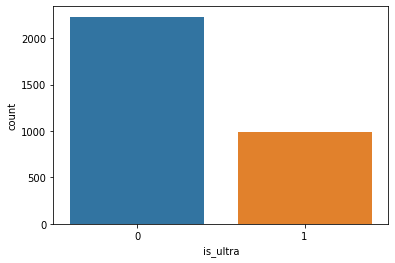

In [5]:
sns.countplot(x='is_ultra', data=churn_data);

In [6]:
churn_data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Построим так же графики совместного распределения призкаков для каждого класса. 

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


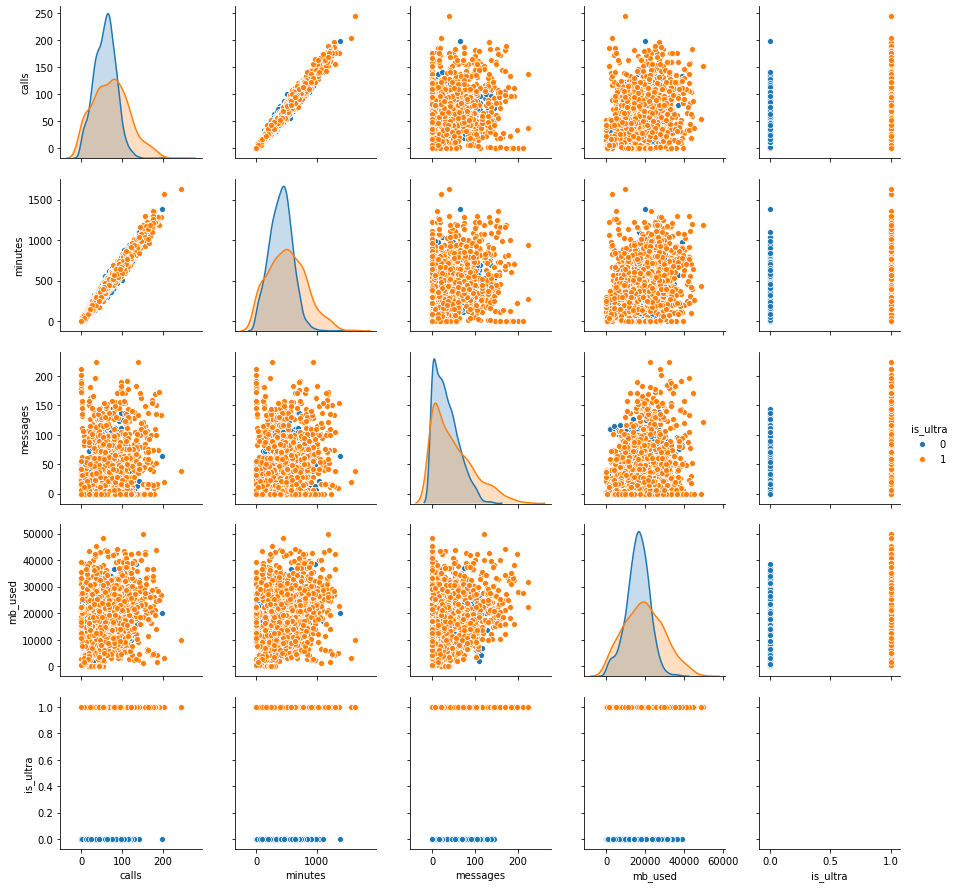

In [7]:
sns.pairplot(churn_data, hue ='is_ultra');

### Вывод

Всего в датасете содержится 3214 записи, из которых 985 отсносятся к тарифу "Ультра", а 2229 - к тарифу "Смарт". Вывод по распределению данных по тарифам в целом остается прежним. Пользователи тарифа Ультра в среднем говорят, пишут и сидят в интернете больше, чем пользоатели тарифа Смарт. При этом визуально разделить два этих класа достаточно затруднительно.   

Целевой признак содержит 2 класса, следовательно перед нами стоит задача бинарной классификации.

## Комментарий наставника
<span style="color:green">Прекрасный анализ, молодец! Ещё и графики построены:) Очень круто!</span>

## 2. Разбейте данные на выборки

Разделим сначала датасет на две части: X - содержащий признаки и y - содержащий метки классов. 

In [8]:
X = churn_data.iloc[:, 0:4].values
y = churn_data.iloc[:, 4].values

Теперь разделим полученные данные на тренировочную, валидационную и тестовую часть в соотношении 60:20:20

Сначала на тренировочно-валидационную и тестовую.

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

И далее тренировочно-валидационную разобьем на собственно тренировочную и валидационую. 

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

Проверим размеры полученных частей. 

In [11]:
print(len(X_train), len(X_val), len(X_test))

1928 643 643


### Вывод 

Исходные данные разбиты на тренировочную, валидационную и тестовую часть в выбраном соотношении.

## 3. Исследуйте модели

В данной работе будем проверять качество трех моделей, а так же настроим их гиперпараметры. Среди используемых моделей будет - решающее дерево, случайный лес, а так же логистическая регрессия и метод опорных векторов. 

- Логистическая регрессия

Начнем с логистической регрессии. Методы использующие логистическую регрессию очень быстрые, и хорошо работают на больших выборках, где данных и признаков Очень много. У нас, впрочем, не такой случай и, возможно, линейная регрессия в нашем случае будет работать несколько хуже чем другие методы.

К тому же логистическая регрессия проста и не требует настройки гиперпараметров.

Обучим логистическую регрессию на тестовой выборке.

In [12]:
logreg_model = LogisticRegression(random_state=42)

In [13]:
logreg_model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Предскажем класс по валидационной выборке

In [14]:
logreg_pred = logreg_model.predict(X_val)

Проверим полученные предсказания с помощью метрики accuracy_score

In [15]:
accuracy_score(logreg_pred, y_val)

0.7216174183514774

72% правильных ответов на валидационной выборке. Неплохо, но и не очень хорошо. 

___

- Решающее дерево

У решающего дерева есть некоторые плюсы по сравнению с другими моделями. Возможно оно не слишком точное, однако его результаты легко интерпретируются человеком. 

Посмотрим, как решающее дерево работает из коробки. 

In [16]:
tree_model = DecisionTreeClassifier(random_state=42)

In [17]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [18]:
tree_pred = tree_model.predict(X_val)

In [19]:
accuracy_score(tree_pred, y_val)

0.7309486780715396

Чуть лучше линейной регрессии, однако мы еще не настраивали параметры. Сделаем это. Но сначала немного магии. Нарисуем дерево!

In [20]:
from sklearn import tree

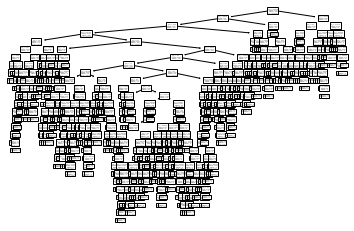

In [21]:
tree.plot_tree(tree_model);

Магия говорит, что дерево переобучилось. Сильно. Больше похоже на виноград. Нам необходимо ограничить максимальную глубину дерева и число образцов в листе. Посмотрим в цикле, с какой глубиной дерево будет показывать лучшие результаты. Будем изменять глубину дерева от 1 до 15.

In [22]:
accuracy = []
max_depth = range(1,15)
for i in max_depth:
    tree_model_tuned = DecisionTreeClassifier(max_depth=i, random_state=42)
    tree_model_tuned.fit(X_train, y_train)
    pred_acc = accuracy_score(tree_model_tuned.predict(X_val), y_val)
    accuracy.append(pred_acc)
    print(pred_acc)

0.7418351477449455
0.7744945567651633
0.7744945567651633
0.7807153965785381
0.7713841368584758
0.7791601866251944
0.7884914463452566
0.7713841368584758
0.7853810264385692
0.7651632970451011
0.7667185069984448
0.7682737169517885
0.7573872472783826
0.7636080870917574


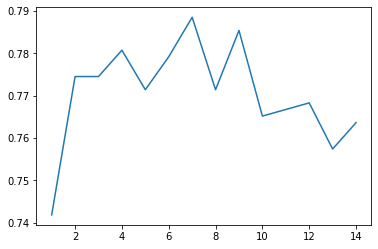

In [23]:
plt.plot(list(max_depth), accuracy);

Видно, что после глубины в 7 accuracy начинает падать, что значит, что дерево начинает переобучаться.

Зафиксируем значения максимальной глубины равным 7 и переберем настроим минимальное число образцов в листе. 

In [24]:
accuracy = []
min_samples_leaf = range(1,20,2)
for i in min_samples_leaf:
    tree_model_tuned = DecisionTreeClassifier(max_depth=7, min_samples_leaf=i, random_state=42)
    tree_model_tuned.fit(X_train, y_train)
    pred_acc = accuracy_score(tree_model_tuned.predict(X_val), y_val)
    accuracy.append(pred_acc)
    print(pred_acc)

0.7884914463452566
0.7776049766718507
0.7698289269051322
0.776049766718507
0.7838258164852255
0.7853810264385692
0.7884914463452566
0.7853810264385692
0.7791601866251944
0.7791601866251944


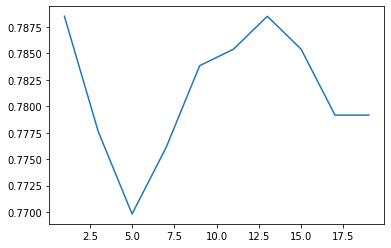

In [25]:
plt.plot(list(min_samples_leaf), accuracy);

Самые точные результаты получаются, когда минимально возможное число элементов в листе равно 1. Есть вероятность, что на больших данных это может привести к переобучению, однако пока оставим все как есть. Отрисуем полученное настройкой гиперпараметров дерево. 

In [26]:
tree_model_tuned = DecisionTreeClassifier(max_depth=7, min_samples_leaf=1, random_state=42)

In [27]:
tree_model_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [28]:
accuracy_score(tree_model_tuned.predict(X_val), y_val)

0.7884914463452566

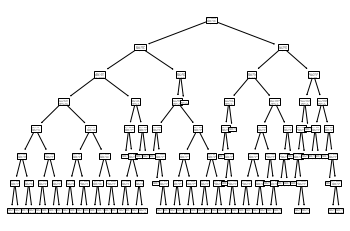

In [29]:
tree.plot_tree(tree_model_tuned);

Точность повысилось и дерево стало гораздо презентабельнее (хотя прочитать по нему все еще достаточно сложно. Видимо данные все еще слишком сложны для интуитивного представления). 

## Комментарий наставника
<span style="color:green">Класс!</span>

Впрочем, такой метод подбора гиперпараметров имеет некоторые ограничения. В частности, мы всегда проверяем его точность на одной валидационной выборке. Гораздо эффективнее провести подбор гиперпараметров с помощью встроенных методов sklearn. Попробуем подобрать их автоматически, с помощью GridSearchCV. Этот метод, ко всему прочему, проведет кросвалидацию, для каждой пары параметров и подберет лучший. Удобнее чем цикл for, так ведь?) 

Зададим исходные параметры для настройки: max_depth - отвечающий за максимальную глубину дерева, min_samples_leaf - задающий минимальное количество элементов, которые могут находится в одном конечном листе, min_samples_split - задающим минимальное количество элементов, которые должен содержать лист чтобы его можно было разделить на другие.

In [30]:
tree_params = {'max_depth': list(range(1, 10)), 
               'min_samples_leaf': list(range(2, 20, 2)),
               'min_samples_split': list(range(2, 10))}

Для каждого сочетания параметров проводится 5 кратная кросс-валидация. Поэтому передадим туда сразу и тренировочный и валидационный сет.

In [31]:
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params,
cv=5, n_jobs=-1,
verbose=True)

In [32]:
tree_grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:   20.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16,

In [33]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2},
 0.7969661610268378)

Итак, с помощью кроссвалидации определено, что самые лучшие параметры для дерева - 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2. Сравнивать accuracy с остальными деревьями пока рано, мы ведь не дообучили их на валидационном датасете. Сравним эти два способа настройки гиперпараметров позднее.

___

- Случайный лес

Случайны лес - ансамблевый метод классификации, который заключается в усреднении ответов от большого количества решающих деревьев. Проверим как он работает из коробки.

In [34]:
forrest_model = RandomForestClassifier(random_state=42)

In [35]:
forrest_model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [36]:
accuracy_score(forrest_model.predict(X_val), y_val)

0.7667185069984448

Лучше чем ненастроенное дерево, хуже чем настроенное дерево. Попробуем настроить число деревьев и посмотреть что получится. 

In [37]:
accuracy = []
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 400, 500]
for i in n_estimators:
    forrest_tuned_model = RandomForestClassifier(n_estimators = i, random_state=42)
    forrest_tuned_model.fit(X_train, y_train)
    pred_acc = accuracy_score(forrest_tuned_model.predict(X_val), y_val)
    accuracy.append(pred_acc)
    print(pred_acc)

0.7122861586314152
0.7573872472783826
0.7682737169517885
0.7744945567651633
0.776049766718507
0.7916018662519441
0.7947122861586314
0.7947122861586314
0.7978227060653188
0.7993779160186625
0.7947122861586314
0.7962674961119751


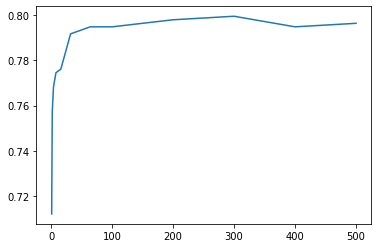

In [38]:
plt.plot(n_estimators, accuracy);

После 32 деревьев качество предсказаний выходит на плато и растет медленно, а после 300 вообще начинает подать. При этом лес с 300 деревьям работает настраивается достаточно медленно. Впрочем, если нам важна точность предсказания, почему бы и не вытянуть лишнего. 

Попробуем так же настроить максимальную грубину деревьев в лесу. 

In [39]:
accuracy = []
max_depth = range(1,15)
for i in max_depth:
    forrest_tuned_model = RandomForestClassifier(n_estimators = 300, max_depth = i, random_state=42)
    forrest_tuned_model.fit(X_train, y_train)
    pred_acc = accuracy_score(forrest_tuned_model.predict(X_val), y_val)
    accuracy.append(pred_acc)
    print(pred_acc)

0.7480559875583204
0.7791601866251944
0.7947122861586314
0.7978227060653188
0.7993779160186625
0.7947122861586314
0.80248833592535
0.8009331259720062
0.7916018662519441
0.7931570762052877
0.7916018662519441
0.7931570762052877
0.7853810264385692
0.7900466562986003


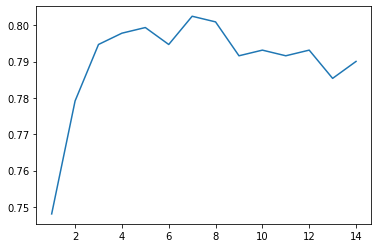

In [40]:
plt.plot(list(max_depth), accuracy);

In [41]:
forrest_tuned_model = RandomForestClassifier(n_estimators = 300, max_depth = 7, random_state=42)

In [42]:
forrest_tuned_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
accuracy_score(forrest_tuned_model.predict(X_val), y_val)

0.80248833592535

Ограничив глубину в 8 получилось достигнуть еще большей accuracy.

Попробуем так же настроить эти параметры с помощью GridSearchCV

In [44]:
forrest_params = {'max_depth': list(range(1, 10)), 
                  'n_estimators': [200, 250, 300, 350, 400]}

In [45]:
forrest_grid = GridSearchCV(RandomForestClassifier(random_state=42), forrest_params,
cv=5, n_jobs=-1,
verbose=True)

In [46]:
forrest_grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  3.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'ma

In [47]:
forrest_grid.best_params_, forrest_grid.best_score_

({'max_depth': 8, 'n_estimators': 300}, 0.8028004667444574)

С помощью GridSearchCV мы получили практически те же результаты, что и ручным нахождением параметров. 

___

### Вывод 

Модели были проверены на валидационных данных. В целом линейные модели показывают на этих данных меньшее значение accuracy, чем модели, основанные на решающих деревьях. 

Значение accuracy моделей на валидационных данных следующее: 

- Логистическая регрессия - 72,16 %
- Решающее дерево из коробки - 73,09 %
- Решающеее дерево настроенное - 78,85 %
- Случайный лес из коробки - 76,67 %
- Случайный лес настроенный - **80,25 %**

Наилучшие результаты показал настроенный случайный лес. Логистическая регрессия справилась хуже всего. 

## 4. Проверьте модель на тестовой выборке

Чтобы проверить модели на тестовых данных сначала дообучим те, которые в предидущих пунктах учились только на тренировочной выборке. 

In [48]:
models = (logreg_model, tree_model, tree_model_tuned, 
          forrest_model, forrest_tuned_model)

In [49]:
for model in models:
    model.fit(X_train_val, y_train_val)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Теперь проверим каждую из моделей на тестовых данных

In [50]:
models_name = ('logreg_model', 'tree_model', 'tree_model_tuned', 'tree_grid', 
          'forrest_model', 'forrest_tuned_model', 'forrest_grid')
models = (logreg_model, tree_model, tree_model_tuned, tree_grid, 
          forrest_model, forrest_tuned_model, forrest_grid)

In [51]:
i = 0
for model in models:
    preds = model.predict(X_test)
    accuracy = accuracy_score(preds, y_test)
    print('Accuracy of {}: {}'.format(models_name[i], accuracy))
    i += 1

Accuracy of logreg_model: 0.7200622083981337
Accuracy of tree_model: 0.7465007776049767
Accuracy of tree_model_tuned: 0.8102643856920684
Accuracy of tree_grid: 0.80248833592535
Accuracy of forrest_model: 0.7869362363919129
Accuracy of forrest_tuned_model: 0.8149300155520995
Accuracy of forrest_grid: 0.8164852255054432


### Вывод

На тестовых данных получены следующие результаты:

- Логистическая регрессия - 72,00 % (на валидации 72,16 %)
- Решающее дерево из коробки - 74,65 % (на валидации 73,09 %)
- Решающеее дерево настроенное вручную - 81,03 % (на валидации 78,85 %)
- Решающее дерево настроенное на кросс-валидации - 80,24 %
- Случайный лес из коробки - 78,69 % (на валидации 76,67 %)
- Случайный лес настроенный вручную - 81,49 % (на валидации *80,25 %*)
- Случайный лес настроенный на кросс-валидации - **81,65 %**

На тестовых данных деревья и лес даже улучшили свои результаты, а вот линейная регрессия чуть снизила accuracy. Вероятнее всего это значит, что она незначитально переобучилась. 

## Комментарий наставника
<span style="color:green">Превосходно!</span>

## 5. (бонус) Проверьте модели на адекватность

Если давать ответы случайно - accuracy будет приблизительно равна 50%. Все наши модели показали лучшие результаты. 

Однако, что у нас есть большой перевес в сторону класса 0. Поэтому можно предположить, что если все что результаты получатся неплохими даже если всем тестовым записям присваивать класс 0. Посмотрим на accuracy в таком случае.

In [52]:
prediction_by_me = np.zeros(len(y_test))

In [53]:
accuracy_score(prediction_by_me, y_test)

0.7076205287713841

70,7%! Можно бы даже было сказать, что это достаточно точно. 

### Вывод

Все модели показывают лучшие результаты, чем предсказание одним классом. Это значит что они действительно способны находить некоторые закономерности в данных. 

# Итоговый вывод

Были исследованы три вида моделей для бинарной классификации - логистическая регрессия, решающее дерево и случайный лес. 

Логистическая регрессия, несмотря на скорость, показывает незначительно лучшие результаты, чем предсказания одним классом и получает на метрике accuracy 72%.

Настройка гипперпараметро моделей деревьев и леса достаточно сильно влияет по на результат по метрике. Результаты деревьев и леса следующие:

 Модель  | Решающее дерево  | Случайный лес 
:------------- |----------------:| -------------:
 Из коробки    | 74,65 % | 78,69 % 
 Настройка вручную  | 81,03 % | 81,49 % 
 Настройка с CV | 80,24 % | **81,65 %**

Accuracy а 81,65 % для настроенного случайного леса позволяет говорить о том, что модель действительно находит взаимосвязи в данных и эту модель можно использовать для реальных предсказаний. 